# Copyright 2022 Cognite AS
# Deploying a Cognite Function via the SDK

In this notebook, we will learn how to deploy the thermal resistance calculation that we performed in the previous section as a Cognite Function. We will also look at how we can enable this calculation to take place every 5 minutes through the use of Cognite scheduling. 


## 1. Authentication and Client Creation

Here we'll create the Cognite client using an interactive flow. Once this client is created, this will be the main way to communicate with the Cognite Data Fusion.

Import and create a client to communicate with the Cognite Data Fusion (CDF)

In [ ]:
from cognite.client import CogniteClient, ClientConfig
from cognite.client.credentials import Token
from msal import PublicClientApplication


# Enter your name here
YOUR_NAME = "Everton-Colling"

# Contact Project Administrator to get these
TENANT_ID = "48d5043c-cf70-4c49-881c-c638f5796997"
CLIENT_ID = "1c224c70-1df2-4f05-964a-753a6731748a"
CDF_CLUSTER = "westeurope-1"
COGNITE_PROJECT = "ds-cognitefunctions"

SCOPES = [f"https://{CDF_CLUSTER}.cognitedata.com/.default"]
TOKEN_URL = f"https://login.microsoftonline.com/{TENANT_ID}/oauth2/v2.0/token"
AUTHORITY_HOST_URI = "https://login.microsoftonline.com"
AUTHORITY_URI = AUTHORITY_HOST_URI + "/" + TENANT_ID
PORT = 53000


def authenticate_azure():

    app = PublicClientApplication(client_id=CLIENT_ID, authority=AUTHORITY_URI)

    # interactive login - make sure you have http://localhost:port in Redirect URI in App Registration as type "Mobile and desktop applications"
    creds = app.acquire_token_interactive(scopes=SCOPES, port=PORT)
    return creds


creds = authenticate_azure()


cnf = ClientConfig(
    client_name="my-special-client",
    project=COGNITE_PROJECT,
    credentials=Token(creds["access_token"]),
    base_url=f"https://{CDF_CLUSTER}.cognitedata.com",
)
client = CogniteClient(cnf)

## 2. Creating the handle function

As shown in the Examples https://github.com/cognitedata/cognite-function-examples/blob/main/examples/01-creating-a-function-from-a-notebook/create-cognite-function.ipynb , we need to create a function called "handle" and put the required calculation code/steps inside it. Importing packages within the handler funtion is for illustrative purpose in this example.

The `thermal_resistance` function that we defined in the previous notebook has been moved to the `tools.py` file for simplicity.

In [ ]:
def handle(client, data=None, secrets=None, function_call_info=None):

    from tools import thermal_resistance
    import datetime
    from datetime import timedelta

    """Handler Function to be Run/Deployed
    Args:
        client : Cognite Client (not needed, it's available to it, when deployed)
        data : data needed by function
        secrets : Any secrets it needs
        function_call_info : any other information about function

    Returns:
        response : response or result from the function
    """

    ts_exids = [
        "pi:163657",
        "pi:163658",
        "pi:160887",
        "pi:191092",
        "pi:163374",
        "pi:160184",
    ]
    column_names = [
        "T_cold_IN",
        "T_cold_OUT",
        "T_hot_IN",
        "T_hot_OUT",
        "Flow_cold",
        "Flow_hot",
    ]
    # Retrieve the data
    start_date = datetime.datetime(2018, 8, 1)
    end_date = start_date + timedelta(minutes=5)
    df = client.datapoints.retrieve_dataframe(
        external_id=ts_exids,
        aggregates=["average"],
        granularity="1m",
        start=start_date,
        end=end_date,
        include_aggregate_name=False,
    )
    df.fillna(method="ffill", inplace=True)
    df.columns = column_names
    # Calculate the Thermal resistance
    df["TR"] = df.apply(lambda x: thermal_resistance(x), axis=1)
    # Return the result as json
    result = df[["TR"]].to_json()
    return result

Before we deploy this Python-function as a Cognite Function, we can verify that it works locally by passing in our previously instantiated CogniteClient and a data-dictionary.

In [ ]:
handle(client)

## 3. Deploying the Function to CDF

If the calculation is simple and basic, doesn't need any external dependencies, it can be created & deployed directly using python-sdk, by passing handle function as a parameter ( for function_handle) in functions.create command, as shown below.

In [ ]:
function_external_id = f"hx_thermal_perf_{YOUR_NAME}"
function_name = f"Thermal Performance Calculation {YOUR_NAME}"

In [ ]:
function = client.functions.create(
    name=function_name,
    external_id=function_external_id,
    function_handle=handle,
    description="Function to Calculate Thermal Performance of Discharge Coolers",
    runtime="py39",
)

This might take few minutes to deploy before function is ready to run. You can check the status as follows:

In [ ]:
import time


def status_check(function):

    start_time = time.time()
    # Repeat until status is ready
    while function.status != "Ready":

        function.update()

        time_elapsed = int(time.time() - start_time)

        print(function.status + f". Waiting for {time_elapsed} seconds", end="\r")

        if function.status == "Failed":
            print("Failed to deploy function")
            break

        time.sleep(5)
    else:
        print(f"Function is successfully deployed. Wait time: {time_elapsed} seconds.")


status_check(function)

If the function has deployed succesfully, then we can try calling it with the SDK.

In [ ]:
call = function.call()
call

Looks like the function has failed, let's investigate the logs to see what has happened.

In [ ]:
call.get_logs()

As logs say `"ModuleNotFoundError: No module named 'tools'"`, it looks like it can't find the thermal resistance function. We can fix this in the next section by making sure that our function has all the packages that it needs to run properly.


## 4. Uploading a folder to Cognite Functions

We have the neat option of uploading the contents of an entire folder to our Cognite Function. To this end, let's create a new folder `hx-thermal-resistance` and put all our code in there.

In this folder you should have the following:
* handler.py
* tools.py
* requirements.txt

The 4 notebook cells below will automatically create the folder and the code files for you. If you encounter any issues while running the shell scripts, you can manually create the folder and files.

* Create directory
* Copy tools.py over to the folder
* Create handler.py in the folder
* Create requirements.txt in the folder

In [ ]:
%%sh
mkdir ../hx-thermal-resistance

In [ ]:
%%sh
cp tools.py ../hx-thermal-resistance/

In [ ]:
%%writefile ../hx-thermal-resistance/handler.py
import datetime
from datetime import timedelta
from tools import thermal_resistance


def handle(client, data=None, secrets=None, function_call_info=None):
    """Handler Function to be Run/Deployed
    Args:
        client : Cognite Client (not needed, it's available to it, when deployed)
        data : data needed by function
        secrets : Any secrets it needs
        function_call_info : any other information about function

    Returns:
        response : response or result from the function
    """

    ts_exids = [
        "pi:163657",
        "pi:163658",
        "pi:160887",
        "pi:191092",
        "pi:163374",
        "pi:160184",
    ]
    column_names = [
        "T_cold_IN",
        "T_cold_OUT",
        "T_hot_IN",
        "T_hot_OUT",
        "Flow_cold",
        "Flow_hot",
    ]
    # Retrieve the data
    start_date = datetime.datetime(2018, 8, 1)
    end_date = start_date + timedelta(minutes=5)
    df = client.datapoints.retrieve_dataframe(
        external_id=ts_exids,
        aggregates=["average"],
        granularity="1m",
        start=start_date,
        end=end_date,
        include_aggregate_name=False,
    )
    df.fillna(method="ffill", inplace=True)
    df.columns = column_names
    # Calculate the Thermal resistance
    df["TR"] = df.apply(lambda x: thermal_resistance(x), axis=1)
    # Return the result as json
    result = df[["TR"]].to_json()
    return result

In [ ]:
%%sh
echo """pandas >= 1.4.3\ncognite-sdk < 6""" > ../hx-thermal-resistance/requirements.txt

In [ ]:
# Delete the function we deployed to avoid duplication errors
client.functions.delete(external_id=function_external_id)

In [ ]:
function = client.functions.create(
    name=function_name,
    external_id=function_external_id,
    folder="../hx-thermal-resistance",  # We will upload this directory
    description="Function to Calculate Thermal Performance of Discharge Coolers",
    owner=YOUR_NAME,
    runtime="py39",
)

In [ ]:
# Check the status if it has been deployed
status_check(function)

In [ ]:
# Check if the function call has been successful
call = function.call()
call

In [ ]:
# Get response
call.get_response()

## 5. Running a Cognite Function on a schedule

When creating function in CDF UI, we can also create the schedule,
- for hourly schedule, enter this cron expression `0 * * * *`
- for daily `0 0 * * *` 
- for every minute `* * * * *` 

In [ ]:
from getpass import getpass

CLIENT_SECRET = getpass()

In [ ]:
client_credentials = {
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
}

schedule = client.functions.schedules.create(
    name="run-function-every-day",
    cron_expression="*/5 * * * *",  # the cron expression runs every 5 minutes
    function_id=function.id,  # we specify the ID of the function we want to schedule
    data={},  # this is the data we wish to call the function with (e.g. time range for calculation)
    description="This schedule runs the function every 5 minutes",
    client_credentials=client_credentials,  # this is a dictionary with 'client_secret' and 'client_id'
)

In [ ]:
client.functions.calls.list(function_external_id=function_external_id)

## 6. Checking the Cognite Function on the CDF UI

You should be able to see your Cognite Function deployed on the CDF UI as shown in the screenshot below. In the next notebook, we will cover in more detail how the UI can also be leveraged to deploy Cognite Functions. 

https://cognite-learn.fusion.cognite.com/ds-cognitefunctions/functions?cluster=westeurope-1.cognitedata.com&env=westeurope-1

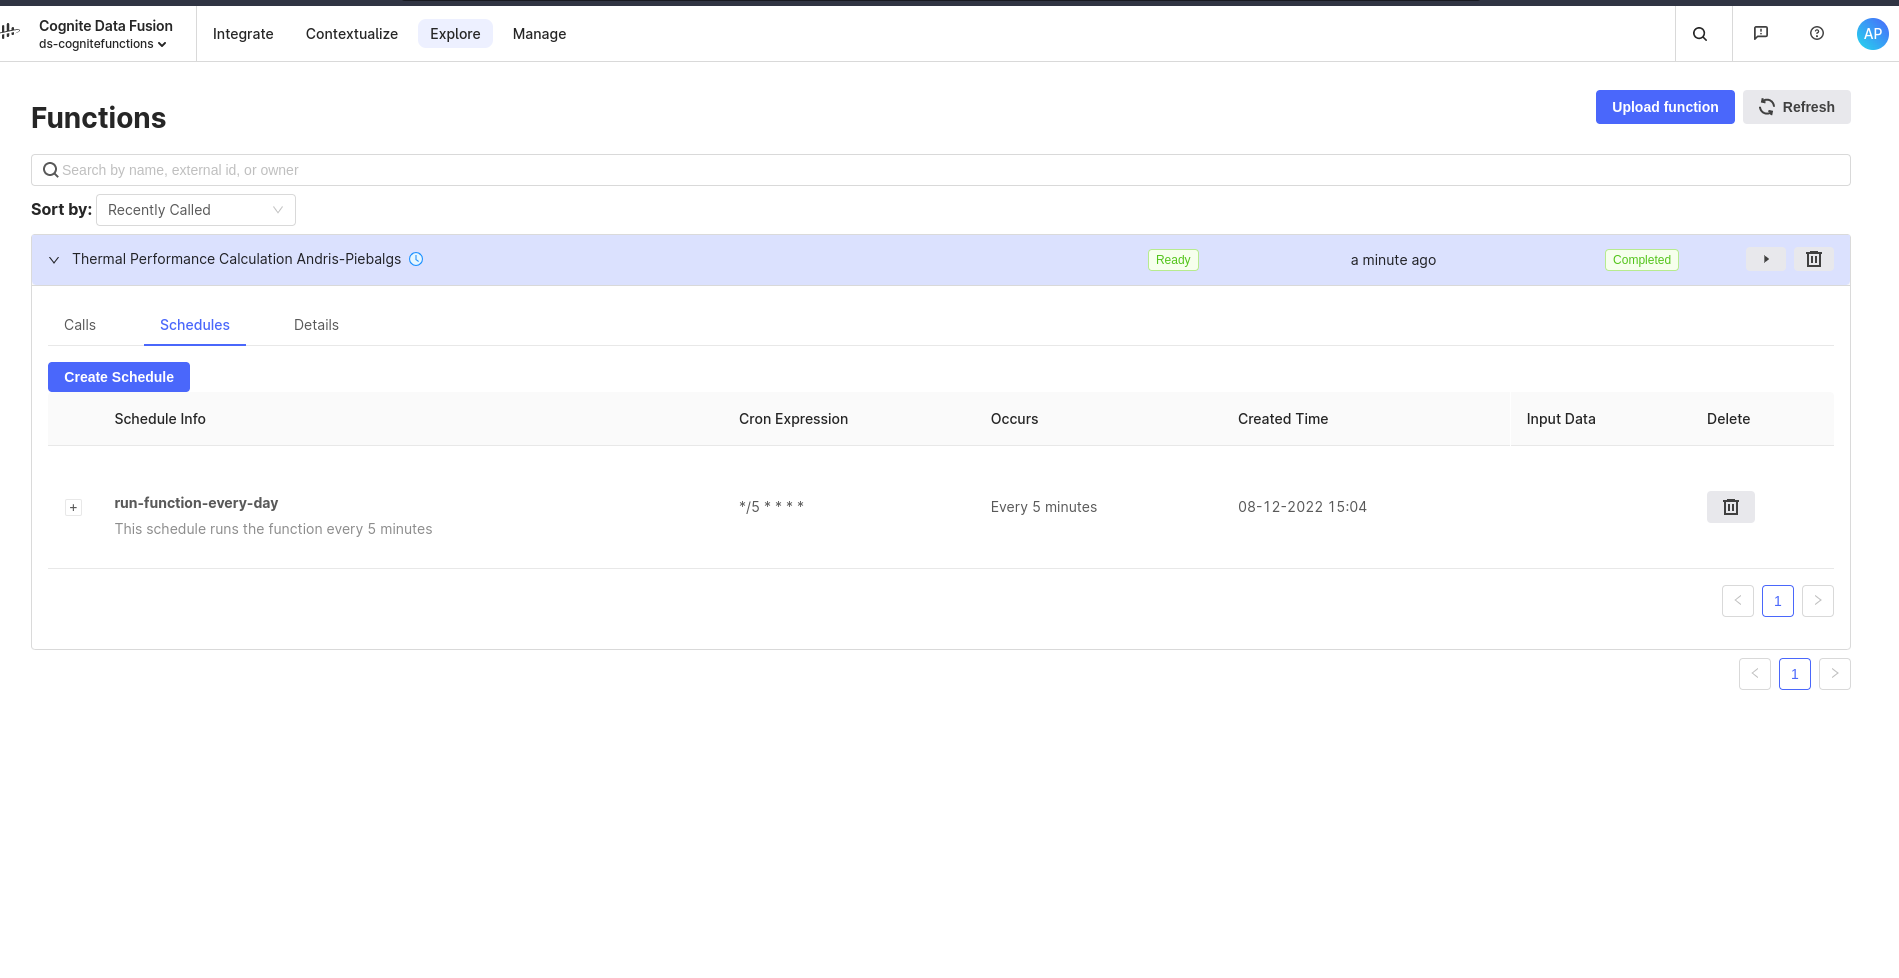



## 7. Deleting the Cognite Function

Let's clean-up and delete the function

In [ ]:
client.functions.delete(external_id=function_external_id)